# Importing necessary libraries

In [1]:
import os, sys, copy, helper, warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import cv2
import csv


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid

import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [2]:
def show_images(dataloader): 
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        break

def accuracy(output, target):
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim = 1)
    equals = top_class == target.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [3]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [4]:
!nvidia-smi

/bin/bash: /home/sysadm/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jun 26 18:58:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        On   | 00000000:2D:00.0  On |                  Off |
| 31%   43C    P2    25W / 250W |   5552MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--

# Setting necessary paths

In [5]:
path = '/home/sysadm/Documents/3ml_kkm/env/chest_xray'
train_dir = path + '/train'
test_dir = path + '/test'

# Creating dataframe with data stats

In [6]:
n_train = []
n_test = []
classes = ['PNEUMONIA', 'NORMAL']
for c in classes:
    train_images = os.listdir(train_dir + '/' + c)
    n_train.append(len(train_images))
    test_images = os.listdir(test_dir + '/' + c)
    n_test.append(len(test_images))
  

In [7]:
print(n_train)
print(n_test)

[3884, 1349]
[390, 235]


In [8]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0  PNEUMONIA   3884   390
1     NORMAL   1349   235



# Visualising data stats

In [9]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Train')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Training data',fontsize=15);

In [10]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Test')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Test data',fontsize=15);

# Creating dataframe from images and labels


In [11]:
# train set

ptrain = []
ctrain = []
for folder_name in classes:
    for files in os.listdir(train_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = train_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptrain.append(path)
            ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in classes:
    for files in os.listdir(test_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = test_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptest.append(path)
            ctest.append(clss)

In [12]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)


,Path,Class
0,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
1,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
2,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
3,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
4,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
5,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
6,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
7,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
8,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
9,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA


# Data to csv

In [13]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

# Defining transformations for data augumentation

In [14]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

# Creating Custom Dataloader

In [15]:
class PneumoniaDataset():
    def __init__(self,df,labels,transform=True):
        self.df = df
        self.labels=list(df.iloc[:,1])
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.loc[idx]
        img_file, img_class = row['Path'], row['Class']
        img = Image.open(img_file).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img,img_class

In [16]:
class_dict = {'NORMAL':0, 'PNEUMONIA':1}
train_data = PneumoniaDataset(train_df,class_dict,transform = train_transforms)
test_data = PneumoniaDataset(test_df,class_dict,transform = test_transforms)

# verifying the dataloader

print(len(train_data))
next(iter(train_data))

5232


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

In [17]:
print(len(test_data))
next(iter(test_data))

624


(tensor([[[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020,

# Splitting training data into training and validation sets

In [18]:
# training indices to be used for validation
num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [19]:
# defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
# loading the data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

# Building the model

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

We have trained this model twice - with 2 different optimisers:


*   Adam
*   SGD with Nesterov accelaration

These are known to produce the best results in image classification problems. The training given below has been done on Adam. To use SGD with Nesterov accelaration instead, use the commented out optimizer instead of the one used below.









In [22]:
# specifying the loss function (categorical cross-entropy)

model = ConvNet()
criterion = nn.CrossEntropyLoss()

# specifying optimizer

# optimizer = optim.Adam(model.parameters(), lr = 0.008, weight_decay = 0.02)
optimizer = optim.SGD(model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    model.cuda()

print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2)

In [23]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'


# Training and validating the model


In [24]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = "Train Model/Epoch: "):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model.train()
    for data, target in tqdm(train_loader, desc = 'Model Train: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model.eval()
    for data, target in tqdm(valid_loader, desc = 'Model validation: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './../models/model_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 12.130404 	Validation Loss: 6.404604 
		Training Accuracy: 0.835090 	Validation Accuracy: 0.932894
Validation loss decreased (inf --> 6.404604).  Saving model ...



Epoch: 2 	Training Loss: 5.771702 	Validation Loss: 4.200824 
		Training Accuracy: 0.928096 	Validation Accuracy: 0.959853
Validation loss decreased (6.404604 --> 4.200824).  Saving model ...



Epoch: 3 	Training Loss: 4.499721 	Validation Loss: 4.480832 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.946520



Epoch: 4 	Training Loss: 4.309456 	Validation Loss: 4.069782 
		Training Accuracy: 0.943631 	Validation Accuracy: 0.957802
Validation loss decreased (4.200824 --> 4.069782).  Saving model ...



Epoch: 5 	Training Loss: 4.270419 	Validation Loss: 4.065119 
		Training Accuracy: 0.944346 	Validation Accuracy: 0.958901
Validation loss decreased (4.069782 --> 4.065119).  Saving model ...



Epoch: 6 	Training Loss: 4.382748 	Validation Loss: 4.167979 
		Training Accuracy: 0.945804 	Validation Accuracy: 0.953187



Epoch: 7 	Training Loss: 4.359465 	Validation Loss: 3.986577 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.960000
Validation loss decreased (4.065119 --> 3.986577).  Saving model ...



Epoch: 8 	Training Loss: 4.278184 	Validation Loss: 4.159935 
		Training Accuracy: 0.948334 	Validation Accuracy: 0.955751



Epoch: 9 	Training Loss: 4.322472 	Validation Loss: 4.094074 
		Training Accuracy: 0.945030 	Validation Accuracy: 0.954139



Epoch: 10 	Training Loss: 4.315939 	Validation Loss: 3.945016 
		Training Accuracy: 0.944554 	Validation Accuracy: 0.957949
Validation loss decreased (3.986577 --> 3.945016).  Saving model ...



Epoch: 11 	Training Loss: 4.364287 	Validation Loss: 4.087571 
		Training Accuracy: 0.946191 	Validation Accuracy: 0.956190



Epoch: 12 	Training Loss: 4.348328 	Validation Loss: 4.304792 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.955897



Epoch: 13 	Training Loss: 4.350582 	Validation Loss: 3.991538 
		Training Accuracy: 0.945983 	Validation Accuracy: 0.957949



Epoch: 14 	Training Loss: 4.348733 	Validation Loss: 4.113078 
		Training Accuracy: 0.947143 	Validation Accuracy: 0.956850



Epoch: 15 	Training Loss: 4.329986 	Validation Loss: 4.072866 
		Training Accuracy: 0.943393 	Validation Accuracy: 0.959853



Epoch: 16 	Training Loss: 4.220747 	Validation Loss: 4.230077 
		Training Accuracy: 0.947679 	Validation Accuracy: 0.953846



Epoch: 17 	Training Loss: 4.169434 	Validation Loss: 4.066190 
		Training Accuracy: 0.946905 	Validation Accuracy: 0.958901



Epoch: 18 	Training Loss: 4.161158 	Validation Loss: 4.051323 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.958901



Epoch: 19 	Training Loss: 4.332716 	Validation Loss: 4.246300 
		Training Accuracy: 0.947887 	Validation Accuracy: 0.956996



Epoch: 20 	Training Loss: 4.351172 	Validation Loss: 3.999628 
		Training Accuracy: 0.945715 	Validation Accuracy: 0.958755



Epoch: 21 	Training Loss: 4.437251 	Validation Loss: 4.089055 
		Training Accuracy: 0.947411 	Validation Accuracy: 0.959048



Epoch: 22 	Training Loss: 4.209323 	Validation Loss: 4.153076 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.955751



Epoch: 23 	Training Loss: 4.328883 	Validation Loss: 4.180788 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.956850



Epoch: 24 	Training Loss: 4.230523 	Validation Loss: 3.911035 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.958462
Validation loss decreased (3.945016 --> 3.911035).  Saving model ...



Epoch: 25 	Training Loss: 4.302601 	Validation Loss: 4.155242 
		Training Accuracy: 0.947471 	Validation Accuracy: 0.954139



Epoch: 26 	Training Loss: 4.308821 	Validation Loss: 4.006656 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.958095



Epoch: 27 	Training Loss: 4.380282 	Validation Loss: 4.068754 
		Training Accuracy: 0.944048 	Validation Accuracy: 0.951282



Epoch: 28 	Training Loss: 4.252586 	Validation Loss: 4.201415 
		Training Accuracy: 0.947947 	Validation Accuracy: 0.955897



Epoch: 29 	Training Loss: 4.431564 	Validation Loss: 4.086909 
		Training Accuracy: 0.947441 	Validation Accuracy: 0.956996



Epoch: 30 	Training Loss: 4.175761 	Validation Loss: 3.965556 
		Training Accuracy: 0.950953 	Validation Accuracy: 0.955092



Epoch: 31 	Training Loss: 4.185824 	Validation Loss: 4.142957 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.956557



Epoch: 32 	Training Loss: 4.397198 	Validation Loss: 4.002323 
		Training Accuracy: 0.942173 	Validation Accuracy: 0.955092



Epoch: 33 	Training Loss: 4.347850 	Validation Loss: 4.128003 
		Training Accuracy: 0.944316 	Validation Accuracy: 0.954945



Epoch: 34 	Training Loss: 4.230422 	Validation Loss: 4.065247 
		Training Accuracy: 0.953363 	Validation Accuracy: 0.958095



Epoch: 35 	Training Loss: 4.246726 	Validation Loss: 4.140699 
		Training Accuracy: 0.948155 	Validation Accuracy: 0.956850



Epoch: 36 	Training Loss: 4.420579 	Validation Loss: 4.037970 
		Training Accuracy: 0.944048 	Validation Accuracy: 0.957802



Epoch: 37 	Training Loss: 4.379599 	Validation Loss: 4.171751 
		Training Accuracy: 0.947411 	Validation Accuracy: 0.952235



Epoch: 38 	Training Loss: 4.200333 	Validation Loss: 4.177800 
		Training Accuracy: 0.949286 	Validation Accuracy: 0.954286



Epoch: 39 	Training Loss: 3.995597 	Validation Loss: 4.107041 
		Training Accuracy: 0.950953 	Validation Accuracy: 0.957143



Epoch: 40 	Training Loss: 4.548267 	Validation Loss: 4.010135 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.956850



Epoch: 41 	Training Loss: 4.141292 	Validation Loss: 4.030893 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.955092



Epoch: 42 	Training Loss: 4.410114 	Validation Loss: 4.087640 
		Training Accuracy: 0.947709 	Validation Accuracy: 0.954945



Epoch: 43 	Training Loss: 4.263850 	Validation Loss: 4.037512 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.953993



Epoch: 44 	Training Loss: 4.367506 	Validation Loss: 4.195804 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.950183



Epoch: 45 	Training Loss: 4.376528 	Validation Loss: 4.165544 
		Training Accuracy: 0.949108 	Validation Accuracy: 0.953333



Epoch: 46 	Training Loss: 4.132844 	Validation Loss: 4.193391 
		Training Accuracy: 0.947173 	Validation Accuracy: 0.958095



Epoch: 47 	Training Loss: 4.581501 	Validation Loss: 4.271898 
		Training Accuracy: 0.943334 	Validation Accuracy: 0.951135



Epoch: 48 	Training Loss: 4.288810 	Validation Loss: 4.044638 
		Training Accuracy: 0.948363 	Validation Accuracy: 0.955238



Epoch: 49 	Training Loss: 4.417980 	Validation Loss: 4.215823 
		Training Accuracy: 0.946905 	Validation Accuracy: 0.955897



Epoch: 50 	Training Loss: 4.278712 	Validation Loss: 4.148955 
		Training Accuracy: 0.950060 	Validation Accuracy: 0.960000



Epoch: 51 	Training Loss: 4.491630 	Validation Loss: 4.217561 
		Training Accuracy: 0.945030 	Validation Accuracy: 0.952381



Epoch: 52 	Training Loss: 4.402398 	Validation Loss: 3.809084 
		Training Accuracy: 0.944792 	Validation Accuracy: 0.959707
Validation loss decreased (3.911035 --> 3.809084).  Saving model ...



Epoch: 53 	Training Loss: 4.251681 	Validation Loss: 3.972929 
		Training Accuracy: 0.947173 	Validation Accuracy: 0.956996



Epoch: 54 	Training Loss: 4.440979 	Validation Loss: 4.118080 
		Training Accuracy: 0.944613 	Validation Accuracy: 0.956190



Epoch: 55 	Training Loss: 4.405969 	Validation Loss: 4.071386 
		Training Accuracy: 0.946488 	Validation Accuracy: 0.956996



Epoch: 56 	Training Loss: 4.257911 	Validation Loss: 3.897861 
		Training Accuracy: 0.941221 	Validation Accuracy: 0.959048



Epoch: 57 	Training Loss: 4.519561 	Validation Loss: 3.937258 
		Training Accuracy: 0.945506 	Validation Accuracy: 0.959707



Epoch: 58 	Training Loss: 4.367214 	Validation Loss: 4.075514 
		Training Accuracy: 0.950953 	Validation Accuracy: 0.959048



Epoch: 59 	Training Loss: 4.211679 	Validation Loss: 4.094442 
		Training Accuracy: 0.945983 	Validation Accuracy: 0.957949



Epoch: 60 	Training Loss: 4.327670 	Validation Loss: 4.096696 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.952234



Epoch: 61 	Training Loss: 4.347690 	Validation Loss: 4.246369 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.952234



Epoch: 62 	Training Loss: 4.261625 	Validation Loss: 4.010148 
		Training Accuracy: 0.948096 	Validation Accuracy: 0.959048



Epoch: 63 	Training Loss: 4.244298 	Validation Loss: 4.045471 
		Training Accuracy: 0.947947 	Validation Accuracy: 0.955092



Epoch: 64 	Training Loss: 4.200922 	Validation Loss: 3.938579 
		Training Accuracy: 0.950477 	Validation Accuracy: 0.955898



Epoch: 65 	Training Loss: 4.412503 	Validation Loss: 4.061944 
		Training Accuracy: 0.946191 	Validation Accuracy: 0.956850



Epoch: 66 	Training Loss: 4.115805 	Validation Loss: 4.031194 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.956996



Epoch: 67 	Training Loss: 4.251759 	Validation Loss: 4.002018 
		Training Accuracy: 0.946518 	Validation Accuracy: 0.957949



Epoch: 68 	Training Loss: 4.490335 	Validation Loss: 4.053741 
		Training Accuracy: 0.946429 	Validation Accuracy: 0.961905



Epoch: 69 	Training Loss: 4.369673 	Validation Loss: 4.203138 
		Training Accuracy: 0.945983 	Validation Accuracy: 0.950183



Epoch: 70 	Training Loss: 4.212343 	Validation Loss: 4.090177 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.957143



Epoch: 71 	Training Loss: 4.359854 	Validation Loss: 4.156386 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.956044



Epoch: 72 	Training Loss: 4.447211 	Validation Loss: 4.195151 
		Training Accuracy: 0.945268 	Validation Accuracy: 0.956044



Epoch: 73 	Training Loss: 4.194135 	Validation Loss: 4.099994 
		Training Accuracy: 0.948125 	Validation Accuracy: 0.956850



Epoch: 74 	Training Loss: 4.531347 	Validation Loss: 4.018691 
		Training Accuracy: 0.947858 	Validation Accuracy: 0.959048



Epoch: 75 	Training Loss: 4.365176 	Validation Loss: 4.105017 
		Training Accuracy: 0.945000 	Validation Accuracy: 0.952381



Epoch: 76 	Training Loss: 4.472087 	Validation Loss: 3.998109 
		Training Accuracy: 0.946429 	Validation Accuracy: 0.953993



Epoch: 77 	Training Loss: 4.196369 	Validation Loss: 4.058885 
		Training Accuracy: 0.948602 	Validation Accuracy: 0.960806



Epoch: 78 	Training Loss: 4.096185 	Validation Loss: 4.059744 
		Training Accuracy: 0.947887 	Validation Accuracy: 0.955751



Epoch: 79 	Training Loss: 4.179162 	Validation Loss: 4.015775 
		Training Accuracy: 0.948125 	Validation Accuracy: 0.957949



Epoch: 80 	Training Loss: 4.416163 	Validation Loss: 4.159703 
		Training Accuracy: 0.945507 	Validation Accuracy: 0.956044



Epoch: 81 	Training Loss: 4.271208 	Validation Loss: 4.128995 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.955238



Epoch: 82 	Training Loss: 4.534638 	Validation Loss: 4.071485 
		Training Accuracy: 0.947441 	Validation Accuracy: 0.957802



Epoch: 83 	Training Loss: 4.205369 	Validation Loss: 3.926790 
		Training Accuracy: 0.948810 	Validation Accuracy: 0.958901



Epoch: 84 	Training Loss: 4.179311 	Validation Loss: 4.027652 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.958608



Epoch: 85 	Training Loss: 4.116353 	Validation Loss: 4.064411 
		Training Accuracy: 0.948840 	Validation Accuracy: 0.960806



Epoch: 86 	Training Loss: 4.323820 	Validation Loss: 4.149855 
		Training Accuracy: 0.949584 	Validation Accuracy: 0.958901



Epoch: 87 	Training Loss: 4.329236 	Validation Loss: 4.122540 
		Training Accuracy: 0.946697 	Validation Accuracy: 0.956996



Epoch: 88 	Training Loss: 4.418115 	Validation Loss: 4.147572 
		Training Accuracy: 0.950982 	Validation Accuracy: 0.956703



Epoch: 89 	Training Loss: 4.228243 	Validation Loss: 4.238130 
		Training Accuracy: 0.947143 	Validation Accuracy: 0.953553



Epoch: 90 	Training Loss: 4.281582 	Validation Loss: 3.902593 
		Training Accuracy: 0.949346 	Validation Accuracy: 0.960806



Epoch: 91 	Training Loss: 4.503901 	Validation Loss: 4.105158 
		Training Accuracy: 0.941905 	Validation Accuracy: 0.954139



Epoch: 92 	Training Loss: 4.240901 	Validation Loss: 4.111183 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.956190



Epoch: 93 	Training Loss: 4.213777 	Validation Loss: 4.110462 
		Training Accuracy: 0.948840 	Validation Accuracy: 0.956996



Epoch: 94 	Training Loss: 4.456210 	Validation Loss: 4.062577 
		Training Accuracy: 0.944078 	Validation Accuracy: 0.962711



Epoch: 95 	Training Loss: 4.364740 	Validation Loss: 4.172736 
		Training Accuracy: 0.945953 	Validation Accuracy: 0.953993



Epoch: 96 	Training Loss: 4.246111 	Validation Loss: 3.869202 
		Training Accuracy: 0.949078 	Validation Accuracy: 0.961905



Epoch: 97 	Training Loss: 4.311446 	Validation Loss: 4.060690 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.955751



Epoch: 98 	Training Loss: 4.264484 	Validation Loss: 4.131562 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.959048



Epoch: 99 	Training Loss: 4.303159 	Validation Loss: 4.073737 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.959853



Epoch: 100 	Training Loss: 4.339625 	Validation Loss: 3.930868 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.966520



In [36]:
print('Total pretrained parameters: ', sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total trainable parameter: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total pretrained parameters:  0
Total trainable parameter:  17697666


# Plotting training/validation losses

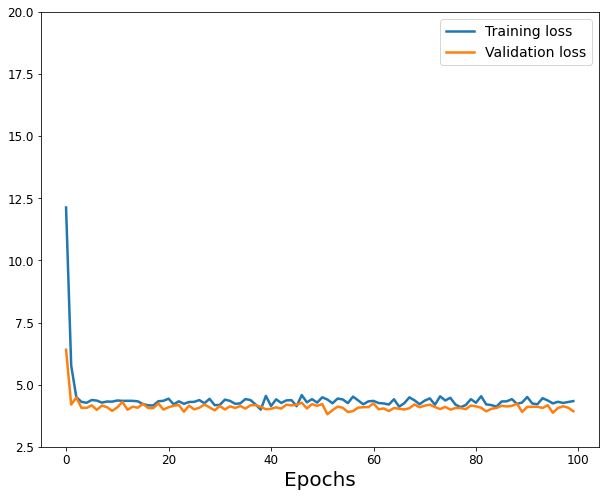

In [37]:

plt.figure(figsize=(10,8))
plt.plot(train_losses,'-',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'-', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

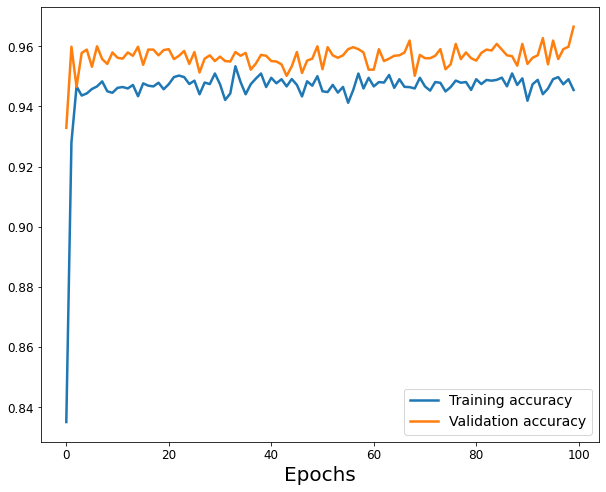

In [38]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'-', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'-', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [28]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'

In [29]:
model.load_state_dict(torch.load('./../models/model_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [39]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterating over test data
for data, target in tqdm(test_loader, desc = 'Model Test: '):
    # moving tensors to GPU if CUDA is available
    data = torch.Tensor(data)
    target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
    target = torch.Tensor(np.array(target))
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.436246

Test Accuracy of PNEUMONIA: 50% (117/234)
Test Accuracy of NORMAL: 98% (384/390)

Test Accuracy (Overall): 80% (501/624)


# Evaulating the model

In [40]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[117., 117.],
        [  6., 384.]])


In [41]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.7665
Recall: 0.9846
F1 Score: 0.8620


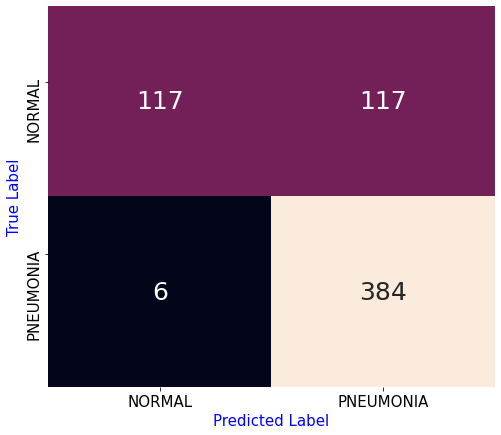

In [42]:
plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 25})
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, fmt=".0f", cbar = False)
plt.xticks([0.5,1.5], xticks, fontsize = 15); plt.yticks([0.4,1.3], xticks, fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15, color = 'b')
plt.ylabel('True Label', fontsize = 15, color = 'b');

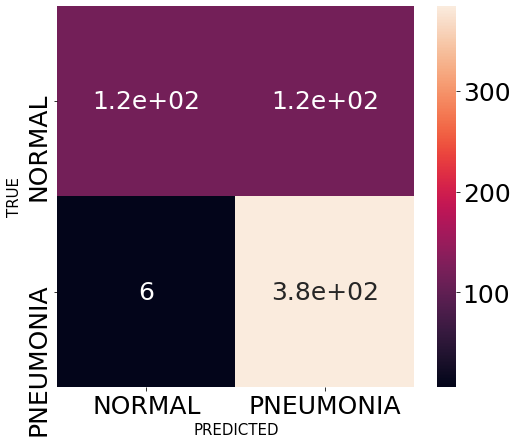

In [43]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15);

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


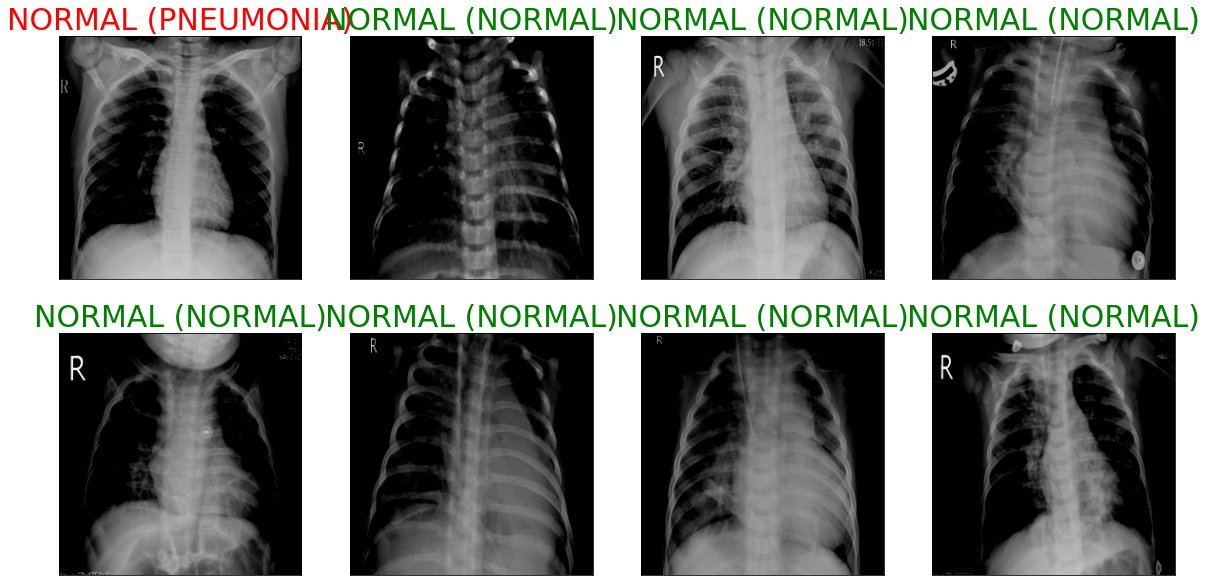

In [44]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

In [46]:
print('Minimum training loss', np.min(train_losses))
print('Minimum validation loss', valid_loss_min)
print('Test loss', test_loss)
print('Maximum training accuracy', np.max(train_acc))
print('Maximum validation accuracy', np.min(valid_acc))
print('Test accuracy for NORMAL class', '50%')
print('Test accuracy for PNEUMONIA class', '98%')
print('Overall test accuracy', '80%')

Minimum training loss 3.995597178276096
Minimum validation loss 3.8090843713709286
Test loss 0.4362455371480722
Maximum training accuracy 0.9533635
Maximum validation accuracy 0.9328936
Test accuracy for NORMAL class 50%
Test accuracy for PNEUMONIA class 98%
Overall test accuracy 80%
